![banner-pdi](https://user-images.githubusercontent.com/58775072/141189378-b5df3287-e8c0-48a1-ad11-825ba317463b.png)

## Universidade Federal de Campina Grande (UFCG)
## Centro de Engenharia Elétrica e Informática (CEEI) 
## Disciplina: Int. ao Processamento de Imagem Digital e Visão Computacional
## Professora: Luciana Ribeiro Veloso
## Aluno(a): José Ewerton Codeiro e Cordeiro

## Observações
***

1. Os arquivos de laboratório devem ser salvos seguindo o seguinte padrão: `lab-x-nome-sobrenome.ipynb`.
2. Não esqueça de colocar o seu nome no cabeçalho acima.
3. Não altere a ordem das células e realize as implementações somente nos campos específicados.  
4. Ao longo do laboratório será solicitado perguntas teóricas relativas aos assuntos das aulas da disciplina e implementações de código utilizando a linguagem de programação Python. 
5. As células de implementação com código serão indicadas pelos seguintes comentários: `# IMPLEMENTE O SEU CÓDIGO AQUI`.
6. Para editar uma célula de texto, basta clicar duas vezes com o cursos do mouse para editar, e `Ctrl + Enter` para finalizar a edição. 
7. Para rodar as células com os códigos desenvolvidos, digite `Ctrl + Enter` ou clique em `Run` no menu do Jupyter.
8. Dúvidas, problemas de execução de código ou dificuldades com a linguagem de programação Python devem ser feitas durante as aulas de laboratório, encaminhadas para o grupo de WhatsApp da turma ou fórum do PVAE da disciplina.
9. Os laboratórios devem ser enviados nos campos especificados pelo PVAE. ATENTE-SE AOS PRAZOS DE ENTREGA!

# <span style="color:red">Laboratório 7.2: Classificação de Dígitos com Redes Neurais Artificiais</span>
***

### Importação dos Pacotes

In [ ]:
import os                                             # operational system para manipulação de arquivos.
import cv2                                            # opencv para manipulação de imagens.
import random                                         # trabalhar com aleatoriedade
import numpy as np                                    # numpy para manipulação de matrizes e arrays.
import matplotlib.pyplot as plt                       # pyplot para plotagem de gráficos e imagens.
from sklearn.model_selection import train_test_split  # função para particionamento dos dados
from tensorflow.keras.models import Sequential        # classe de modelos sequenciais para construir as redes neurais.
from tensorflow.keras.utils import to_categorical     # função para preprocessamento dos gabaritos.
from tensorflow.keras.datasets import mnist           # dataset utilizado nesse experimento.
from tensorflow.keras import layers                   # módulo de camadas do keras
from tensorflow.keras import callbacks                # módulo de callbacks do keras
from tensorflow.keras import optimizers               # módulo de otimizadores do keras

### Banco de Dados

* Vamos utilizar o MNIST, outro banco de dados presente no catálogo de datasets do Keras, que é disponibilizado como uma função pronta;

* Cada instância do banco de dados corresponde a uma imagem rotulada de um dígito manuscrito;

* As imagens do banco de dados são monocromáticas e de dimensões 28 x 28;

* Os gabaritos correspondem ao número manuscrito, sendo um inteiro entre 0 e 9;

* O banco de dados contém 60.000 imagens para treino e 10.000 imagens para teste;

### Organização do banco de dados

* Como vimos, a primeira dimensão dos arrays do banco de dados é reservada para controlar a amostra e as demais correspondem às demais dimensões do tipo de dados utilizado. 

* Nesse caso, os nossos dados são imagens monocromáticas (2D), de modo que são organizados em tensores tridimensionais (3D) com formato: **dados.shape = (amostras, altura, largura)**
    * O i-ésimo exemplo pode ser acessado a partir de: **exemplo = dados[i]**
    * Um pedaço de uma imagem pode ser acessado de forma similar:
        * Quadrante superior esquerdo da i-ésima imagem: **quad = dados[i, :14, :14]**
        

* O banco de dados pode ser carregado utilizando:
    * **(train_data, train_targets), (test_data, test_targets) = mnist.load_data()**
    * train_data é um tensor com as entradas do conjunto de treino;
    * test_data é um tensor com as entradas do conjunto de teste;
    * train_targets é um tensor com os gabaritos do conjunto de treino;
    * test_targets é um tensor com os gabaritos do conjunto de teste;

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


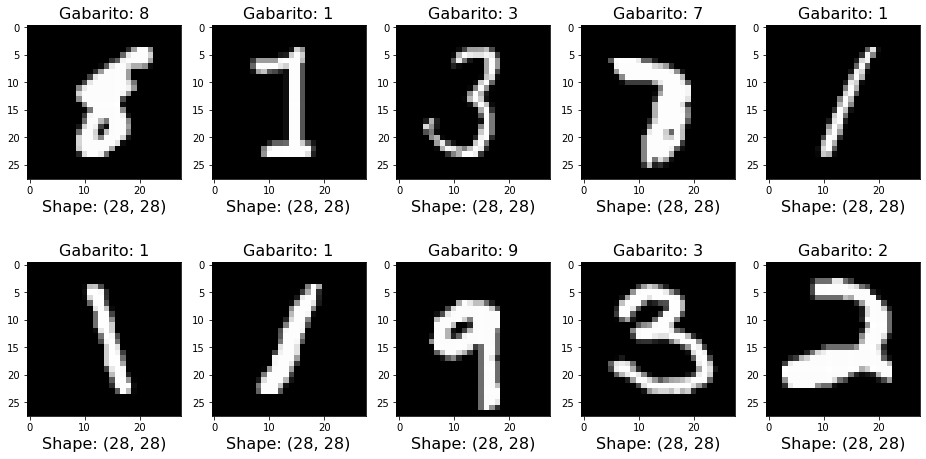

In [ ]:
# escolhe exemplos aleatórios
indices = np.random.randint(0, 60000 - 1, 10)

# plots
fig, axs = plt.subplots(nrows = 2, ncols = 5, figsize=(16, 8))

for i, idx in enumerate(indices):
    
    # plota a imagem
    axs[i // 5][i % 5].imshow(train_images[idx], vmin = 0, vmax = 255, cmap="gray")
    
    # adiciona o gabarito como título
    axs[i//5][i%5].set_title("Gabarito: {}".format(train_labels[idx]), fontsize = 16)
    
    # adiciona o shape como subtítulo
    axs[i//5][i%5].set_xlabel("Shape: {}".format(train_images[idx].shape), fontsize = 16)

### Pre-processamento dos dados de entrada

* Como estamos utilizando Redes Neurais Convolucionais 2D, precisamos que a entrada seja seja um array tetradimensional (4D), sendo necessário adicionar uma dimensão para os canais.

* Para isso, podemos utilizar a função **reshape(shape)** que reorganiza um array para um determinado formato especificado desde que seja possível alocar todos os valores do array original para o novo formato.

* Além disso, como em uma imagem todos os pixels são valores entre 0 e 255, podemos pre-processar os dados de entrada a partir de uma simples divisão por 255, que garante que todos os dados estarão entre 0 e 1.

In [ ]:
def preprocess_data(data):
    
    # desfaz adiciona uma dimensão para os canais da imagem
    data = data.reshape((len(data), 28, 28, 1))
    # normaliza os valores ao dividir pelo maior valor possível dentro das imagens.
    data = data.astype("float32")/255
    return data

preprocessed_train_images = preprocess_data(train_images)
preprocessed_test_images  = preprocess_data(test_images)

## <span style='color:blue'>Questão 1: [Valor da Questão: 2.0][Taxa de acerto: x.x]</span>

* Verifique as dimensões e a faixa de valores dos dados de treino e teste após o pré-processamento. Não é necessário verificar a faixa de valores para cada característica isoladamente.

In [ ]:
print("Treino:", preprocessed_train_images.shape, train_labels.shape)
print("Validação:", preprocessed_test_images.shape, test_labels.shape)

Treino: (60000, 28, 28, 1) (60000,)
Validação: (10000, 28, 28, 1) (10000,)


### Particionamento dos dados de treino

* Agora vamos criar uma partição de validação a partir do conjunto de treino para realizar uma validação cruzada. 

* Novamente vamos utilizar a função **train_test_split**, que separa dados e os seus respectivos gabaritos segundo uma fração especificada.

* Contudo, dessa vez utilizaremos o parâmetro **stratify**, que indica os rótulos associados aos dados fornecidos. Quando esse parâmetro é fornecido a função realiza o particionamento dos dados e mantém a proporção entre exemplos de uma mesma classe com relação aos dados originais.

In [ ]:
# fração escolhida para separar o mesmo número de instâncias do conjunto de testes
data_frac = preprocessed_test_images.shape[0] / preprocessed_train_images.shape[0]

# criação do conjunto de validação
preprocessed_train_images, preprocessed_val_images, train_labels, val_labels = train_test_split(preprocessed_train_images, # dados de treino
                                                                                                train_labels,              # gabaritos de treino
                                                                                                test_size = data_frac,     # proporção de dados p/ validação
                                                                                                stratify = train_labels,   # dados de referência
                                                                                          random_state = 42)         # semente de geração

print("Treino:", preprocessed_train_images.shape, train_labels.shape)
print("Validação:", preprocessed_val_images.shape, val_labels.shape)

Treino: (40000, 28, 28, 1) (40000,)
Validação: (10000, 28, 28, 1) (10000,)


### Pre-processamento dos gabaritos

* Nesse caso temos um problema multiclasse com 10 classes, sendo elas correspondentes aos números entre 0 e 9. Consequentemente, o modelo produzido terá 10 unidades de saída, uma para cada classe, e utilizará a função de ativação softmax.

* Para fornecer esses gabaritos para a rede durante o treinamento é necessário categorizar as saídas, para limitá-las ao intervalo [0, 1]. Para isso vamos utilizar a função to_categorical() disponível no próprio Keras.

In [ ]:
categorical_train_labels = to_categorical(train_labels)
categorical_val_labels = to_categorical(val_labels)
categorical_test_labels = to_categorical(test_labels)

### Construindo o modelo

Para construir o modelo usaremos a classe **Sequential**, que possibilita a construção de modelos sequenciais de forma bastante simples.
* A construção do modelo é feita a partir do seu instanciamento como objeto da classe seguido de chamadas à função **add()** para adicionar camadas.
* Como estamos construindo Redes Neurais Convolucionais, vamos utilizar as camadas **Input**, **Conv2D**, **MaxPooling2D**, **Dropout**, **Flatten** e **Dense**.
    * A camada Input cria a entrada da rede com **Input( shape )**
        * shape corresponde ao formato do tensor de entrada, no nosso caso será o número de características do nosso banco de dados (28, 28, 1);
    * A camada Conv2D pode ser chamada com **Conv2D( num_kernels, kernel_size, activation = 'linear' )**
        * num_kernels corresponde ao número de conjuntos de filtros aplicados, determina o número de mapas de características na saída;
        * kernel_size é uma tupla (altura, largura) que determina o tamanho dos filtros;
        * activation corresponde à função de ativação utilizada na camada;
    * A camada MaxPooling2D pode ser chamada com **MaxPooling2D( kernel_size )**
        * kernel_size é uma tupla (altura, largura) que determina o tamanho dos filtros;
    * A camada Dropout pode ser chamada com **Dropout( drop_chance )**
        * drop_chance é um float que determina a chance de dropout na camada;
    * A camada Flatten pode ser chamada com **Flatten( )**
        * Essa camada "achata" os volumes de dados dos tensores de imagens e transforma em um vetor coluna;
    * A camada Dense pode ser chamada com **Dense( n_unidades, activation = 'linear' )**
        * n_unidades corresponde ao número de neurônios da camada;
        * activation corresponde à função de ativação utilizada na camada;
        
        
* Algumas funções de ativação disponíveis são:
    * "linear"
    * "relu"
    * "sigmoid"
    * "softmax"
    * "tanh"


* Mais informações sobre a camada dense podem ser vistas em **https://keras.io/api/layers/core_layers/dense/**
* Mais informações sobre as ativações disponíveis podem ser vistas em **https://keras.io/api/layers/activations/**

## <span style='color:blue'>Questão 2: [Valor da Questão: 2.0][Taxa de acerto: x.x]</span>

* (a) A função abaixo constroi um modelo de rede neural e utiliza a função summary() para apresentar um resumo das informações da rede neural produzida. Comente o que faz cada linha do código.
* (b) (obrigatório) Modifique parâmetros como o número de filtros de cada camada e/ou o formato do tensor de entrada e/ou o número de saídas.
* (c) Explique como o número de parâmetros de cada camada é calculado. Esse valor depende do tamanho das imagens de entrada?

In [ ]:
# COMENTE AS LINHAS DE CÓDIGO E MODOFIQUE OS PARÂMETROS AQUI --> QUESTÃO 2 - letra (a, b)
def build_model( input_shape, n_outputs ):
    ''''construindo o modelo baseado em redes neurais convolucionais'''
    #cria um objeto do tipo sequential 
    rede = Sequential()
    #adiciona uma camada do tipo input com o shape = input_shape
    rede.add(layers.Input((input_shape)))
    #adiciona uma camada do tipo Conv2D com o tipo de ativação relu e o kernel_size de 3,3
    rede.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    #adiciona uma camada do tipo MaxPoling2D com o pool_size = 2,2
    rede.add(layers.MaxPooling2D(pool_size=(2, 2))) 
    #adiciona uma camada do tipo Dropout com uma chance de queda de 30%
    rede.add(layers.Dropout(rate=0.30))
    #adiciona outra camada Conv2D com as mesmas especificações da anterior
    rede.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    #adiciona outra camada do tipo MaxPooling2D com as mesmas espeficações da anterior
    rede.add(layers.MaxPooling2D(pool_size=(3, 3)))  
    #adiciona outra camada do tipo Droupout com a chance de queda de 30%
    rede.add(layers.Dropout(rate=0.30))
    #adiciona uma camada do tipo Flatten
    rede.add(layers.Flatten())
    #adiciona uma camada do tipo Dense com 128 neuronios e com o tipo de ativação relu
    rede.add(layers.Dense(units=128, activation="relu"))
    #adiciona outra camada do tipo Dense com o numero de neuronios = n_outputs e o tipo de ativação é softmax
    rede.add(layers.Dense(units=n_outputs, activation = "softmax"))
    
    return rede

model = build_model( (28, 28, 1), 10 )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 3, 3, 128)         0

## <span style='color:green'>Resposta da Questão 2:</span>

* Os parâmetros em cada camada é determinado pelos pesos e pelo viés.

In [ ]:
model = build_model((28, 28, 1), 10)
model.compile(optimizer=optimizers.Adam(learning_rate = 1e-3), loss="categorical_crossentropy", metrics=["acc"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 13, 13, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 3, 3, 128)        0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 3, 3, 128)        

### Callbacks

* Dessa vez utilizaremos uma das callbacks do Keras, o Model_Checkpoint.
* Essa função salva o modelo conforme o treinamento é executado à medida que os valores da variável monitorada melhoram, preservando sempre o modelo com os melhores valores obtidos.
* model_checkpoint = ModelCheckpoint( path, monitor = None, save_best_only = True, verbose = 1)
    * path é o caminho para o salvamento do modelo;
    * monitor é a variável que deve ser monitorada pelo callback;
    * save_best_only indica se só o melhor modelo deve ser salvo ou se todos os aumentos devem ser salvos;
    * verbose é o modo de texto, 1 indica para que o Keras avise quando um novo modelo for salvo;

In [ ]:
model_checkpoint = callbacks.ModelCheckpoint("model.hdf5", monitor = "val_acc", save_best_only = True, verbose = 1)

### 8. Treinando o modelo

O treinamento é realizado a partir da função **fit**, que recebe dados de treino e de validação além de hiperparâmetros como o número de épocas e o tamanho dos lotes de dados (batchsize).

* **hist = model.fit( x = None, y = None, epochs = 1, batchsize = None, callbacks = [], validation_data = None, verbose = "auto")**
    * x corresponde aos dados de treino;
    * y corresponde aos gabaritos de treino;
    * epochs corresponde ao número de épocas de treinamento;
    * batchsize corresponde ao tamanho dos lotes entregues à rede de cada vez;
    * callbacks corresponde à lista de callbacks utilizada;
    * validation_data corresponde a uma tupla ( val_data, val_targets ) com os dados de validação;
    * verbose indica como a função deve reportar os resultados:
        * 0: modo silencioso, nenhum retorno em formato de texto;
        * 1: retorno a cada época e barra de progresso;
        * 2: retorno a cada época sem barra de progresso;
    * hist é um dicionário de retorno com os valores de loss e das métricas computadas para treino e validação;
    
    
    
* Lista de callbacks disponíveis: https://keras.io/api/callbacks/

In [ ]:
history = model.fit(preprocessed_train_images, categorical_train_labels, 
                    epochs=10, batch_size=128, callbacks = [model_checkpoint], 
                    validation_data = (preprocessed_val_images, categorical_val_labels))
history_dict = history.history

Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 0.3459 - acc: 0.8923
Epoch 1: val_acc improved from -inf to 0.96700, saving model to model.hdf5
313/313 [==============================] - 60s 189ms/step - loss: 0.3459 - acc: 0.8923 - val_loss: 0.1043 - val_acc: 0.9670
Epoch 2/10
313/313 [==============================] - ETA: 0s - loss: 0.1050 - acc: 0.9673
Epoch 2: val_acc improved from 0.96700 to 0.97880, saving model to model.hdf5
313/313 [==============================] - 58s 184ms/step - loss: 0.1050 - acc: 0.9673 - val_loss: 0.0677 - val_acc: 0.9788
Epoch 3/10
313/313 [==============================] - ETA: 0s - loss: 0.0778 - acc: 0.9749
Epoch 3: val_acc improved from 0.97880 to 0.98360, saving model to model.hdf5
313/313 [==============================] - 65s 207ms/step - loss: 0.0778 - acc: 0.9749 - val_loss: 0.0559 - val_acc: 0.9836
Epoch 4/10
313/313 [==============================] - ETA: 0s - loss: 0.0623 - acc: 0.9801
Epoch 4: val_acc improved from 0.

### Plotagens Gráficas

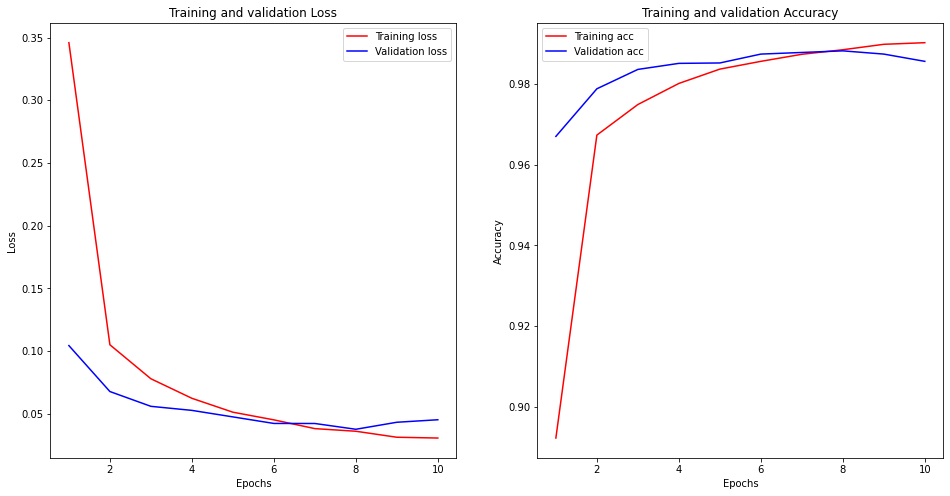

In [ ]:
fig, axes = plt.subplots(1, 2, squeeze = False, figsize = (16,8))

# Loss
train_loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# Epochs
epochs = range(1, len(train_loss_values) + 1)

# Accuracy
train_acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

ax = axes.flat[0]
ax.plot(epochs, train_loss_values, 'r', label='Training loss')
ax.plot(epochs, val_loss_values, 'b', label='Validation loss')
ax.set_title('Training and validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()

ax = axes.flat[1]
ax.plot(epochs, train_acc_values, 'r', label='Training acc')
ax.plot(epochs, val_acc_values, 'b', label='Validation acc')
ax.set_title('Training and validation Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()

### Testes com o Modelo

O teste do modelo pode ser realizado a partir da função **evaluate**, que recebe os dados de treino e retorna o valor de loss calculado para esse conjunto e os valores de cada métrica da lista fornecida durante a compilação do modelo. 

* É uma prática comum realizar ajustes no modelo com base no conjunto de validação e só utilizar o conjunto de testes após a definição dos hiperparâmetros definitivos.
* Como os hiperparâmetros são ajustados a partir dos resultados obtidos para o conjunto de validação, o modelo pode acabar. sobreajustando aos dados de validação, então é interessante mudar os dados desse conjunto com frequência.
* Para mudar os dados de validação basta alterar a semente na função train_test_split.
* Crie um novo modelo do zero após a realização de mudanças nos conjuntos de treino/validação.

## <span style='color:blue'>Questão 3: [Valor da Questão: 4.0][Taxa de acerto: x.x]</span>

* (a) As Redes Convolucionais obtiveram melhores resultados que as Redes Neurais Artificiais nesse banco de dados? 
* (b) Alguma das Redes Neurais Artificiais produzidas na parte 1 obtiveram resultados comparáveis?

In [ ]:
test_loss, test_acc = model.evaluate(preprocessed_test_images, categorical_test_labels)

print("Test Accuracy:", 100*test_acc, "%")
print("Acertos: {} - Erros: {}".format(round(len(preprocessed_test_images)*test_acc), 
                                       round(len(preprocessed_test_images)*(1-test_acc))))

313/313 [==============================] - 4s 13ms/step - loss: 0.0334 - acc: 0.9883
Test Accuracy: 98.83000254631042 %
Acertos: 9883 - Erros: 117


In [ ]:
model.load_weights('model.hdf5')

test_loss, test_acc = model.evaluate(preprocessed_test_images, categorical_test_labels)

print("Test Accuracy:", 100*test_acc, "%")
print("Acertos: {} - Erros: {}".format(round(len(preprocessed_test_images)*test_acc), 
                                       round(len(preprocessed_test_images)*(1-test_acc))))

313/313 [==============================] - 4s 14ms/step - loss: 0.0314 - acc: 0.9888
Test Accuracy: 98.87999892234802 %
Acertos: 9888 - Erros: 112


## <span style='color:green'>Respostas da Questão 3:</span>

* (a) A rede neural convolucional teve um resultado mais preciso neste banco de dados. Utilizando os histogramas desse experimento e os histogramas do experimento passado pode-se notar que, no experimento atual ouve um sobre ajuste menor comparado ao experimento anterior. 
* (b) Os resultados dos dois experimentos foram similares, apesar que o experimento atual teve mais precisão.

### Visualização dos Resultados

In [ ]:
def show_results(xtest, ytest, ypred, num = 25, tipo = "rand"):
    
    if tipo == "acertos":
        fltr_idx = [i for i in range(xtest.shape[0]) if ypred[i] == ytest[i]]
    else:
        fltr_idx = [i for i in range(xtest.shape[0]) if ypred[i] != ytest[i]]
        
    indices = np.random.choice(fltr_idx, min(num, len(fltr_idx)), replace=False)
       
    rows = int(num/5)
    fig, axs = plt.subplots(nrows = rows, ncols = 5, figsize=(20, 4*rows))
    
    for i, idx in enumerate(indices):
        img = xtest[idx]
        if ypred[idx] == ytest[idx]:
            axs[i//5][i%5].set_title(str(ytest[idx]), color = "green", fontsize = 20)
        else:
            axs[i//5][i%5].set_title("Pred: {} - Gabarito: {}".format(ypred[idx], ytest[idx]), color = "red", fontsize = 20)
        
        axs[i//5][i%5].imshow(img, vmin=0, vmax=255, cmap = "gray")
    return

pred_labels = model.predict(preprocessed_test_images, verbose=1)
preds = np.argmax(pred_labels, axis = -1)

313/313 [==============================] - 4s 13ms/step


### Acertos do Modelo

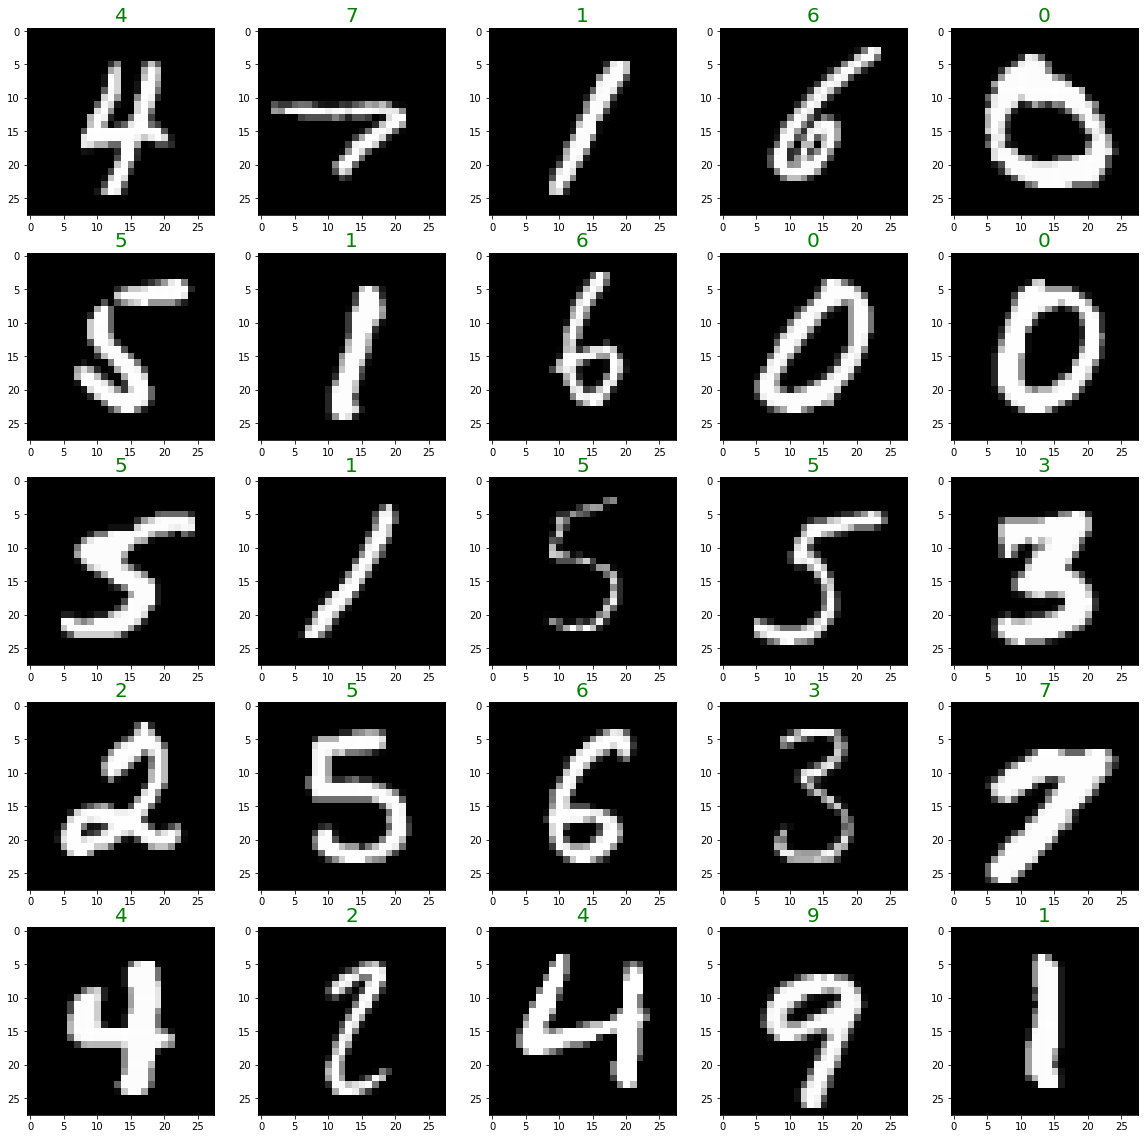

In [ ]:
show_results(test_images, test_labels, preds, tipo = "acertos")

### Erros do Modelo

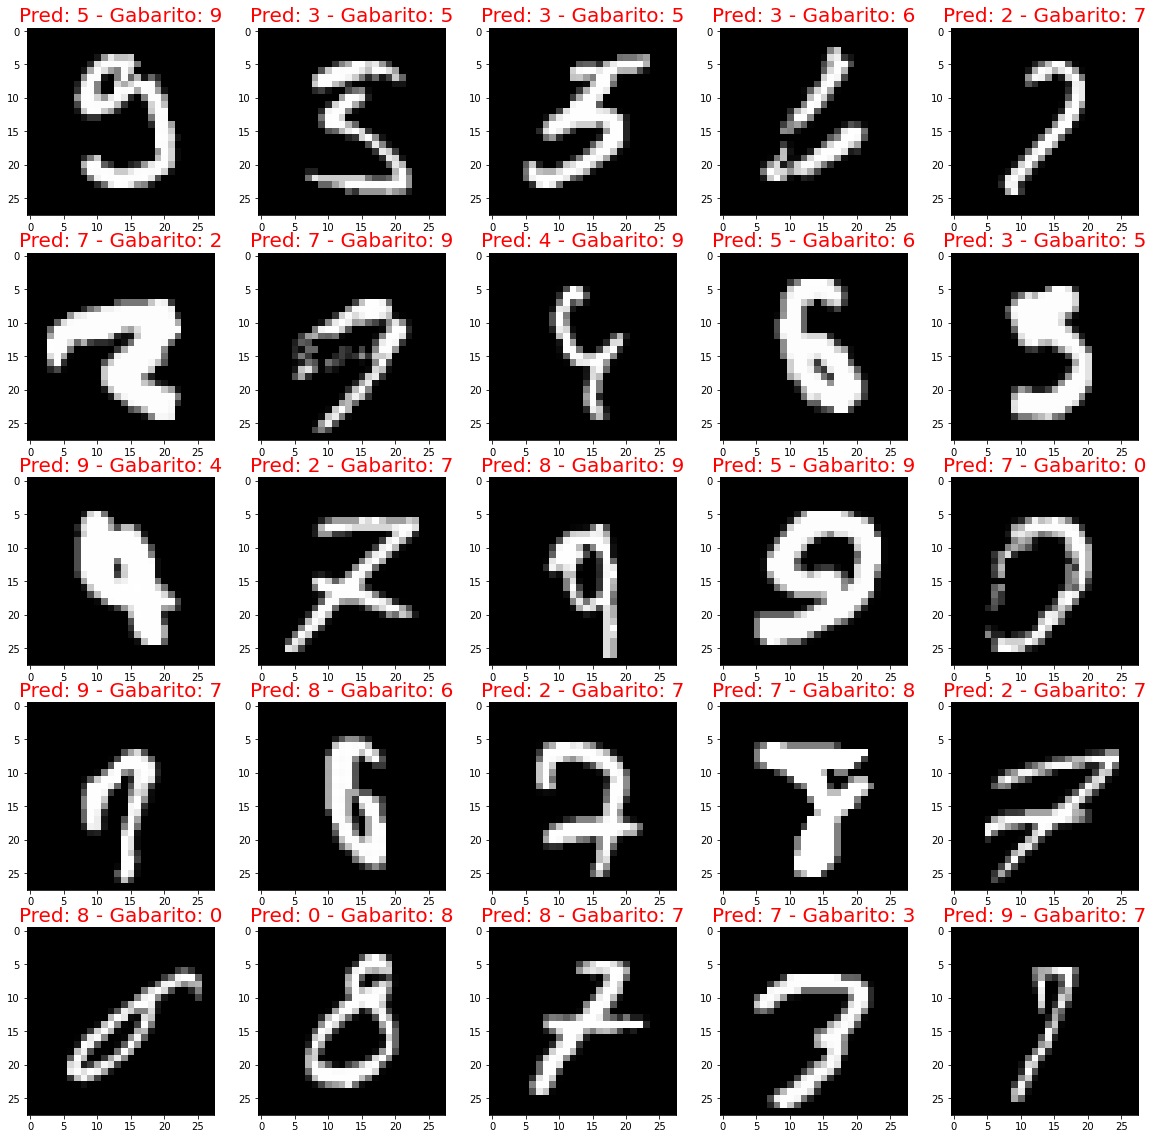

In [ ]:
show_results(test_images, test_labels, preds, tipo = "erros")

## <span style='color:blue'>Questão 4: [Valor da Questão: 2.0][Taxa de acerto: x.x]</span>

* Existe algum padrão nos gabaritos errados que possam confundir a rede em sua análise? Comente utilizando os exemplos vistos na célula acima.

## <span style='color:green'>Resposta da Questão 4:</span>

* Os padrões de erro são causados pelo tipo de caligrafia da pessoa que escreveu os números. Alguns dos principais padrões de erros são alguns trações mal indentificados pelo modelo, tal como: confundir 6 com 0, confundir 7 com 1, confundir 8 com 6, assim por diante.

![gif5](https://user-images.githubusercontent.com/58775072/142713072-0a070f19-b8cb-4ee2-92e5-1a3ec8ded6b2.gif)